# Imports

In [21]:
from dotenv import load_dotenv
import logging

load_dotenv(dotenv_path=".env", verbose=True, override=True)
logging.basicConfig(level=logging.DEBUG)

In [22]:
import os
import json
import random
from collections import namedtuple
from typing import Any
import jsonpickle
import matplotlib.pyplot as plt
import numpy as np

from autocommit_evaluation.core.enums import EnvironmentKey
from autocommit_evaluation.cmg.evaluators import CommitMessageGenerator
from autocommit_evaluation.cmg import evaluator
from autocommit_evaluation.core import (
    main_few_shot_high_level_context_cmg_chain,
    main_zero_shot_low_level_context_cmg_chain,
    main_few_shot_low_level_context_cmg_chain,
    main_zero_shot_high_level_context_cmg_chain,
    main_high_level_context_chain
)
from autocommit.core.models import CommitDataModel, BaseModel
from autocommit_evaluation.datapreparation import context_generator, example_generator
from autocommit_evaluation.result.models import TestCaseScore
from autocommit_evaluation.result.processors import (
    RuleBasedCleaner,
    OutlierCleaner,
    ResultSummarizer,
    BaseCleaner
)
from autocommit.core.constants import END_DOCUMENT_SPLIT_SEPARATOR
from pathlib import Path
import re
from collections import Counter

# Initialization

In [23]:
COMMIT_DATA_JSON_FILE_PATH = os.path.join("autocommit_evaluation", "data", "cmg", "commits.json")
EVALUATION_COMMIT_DATA_JSON_FILE_PATH = os.path.join("autocommit_evaluation", "data", "cmg", "commits.evaluation.json")
TEST_COMMIT_DATA_JSON_FILE_PATH = os.path.join("autocommit_evaluation", "data", "cmg", "commits.test.json")
EXAMPLE_DATA_JSON_FILE_PATH = os.path.join("autocommit_evaluation", "data", "cmg", "commits.example.json")
RESULT_DATA_JSON_FILE_PATH = os.path.join("autocommit_evaluation", "data", "result", "evaluation.json")
SCORE_DATA_JSON_FILE_PATH = os.path.join("autocommit_evaluation", "data", "result", "score.json")

CONTEXT_DATA_PATH = os.path.join("autocommit_evaluation","data", "context")

DEFAULT_CONTEXT_GENERATION_OUTPUT_PATH = os.path.join(
    "autocommit_evaluation", "data", "context"
)
DEFAULT_HIGH_LEVEL_CONTEXT_OUTPUT_PATH = os.path.join(
    "out", "result", "highlevelcontext"
)
DEFAULT_CMG_OUTPUT_PATH = os.path.join("out", "result", "cmg")
DEFAULT_DIFF_CLASSIFICATION_OUTPUT_PATH = os.path.join(
    "out", "result", "diffclassification"
)
DEFAULT_EXAMPLE_GENERATION_OUTPUT_PATH = os.path.join("out", "result", "example")
DEFAULT_CLEANING_RESULT_OUTPUT_PATH = os.path.join("autocommit_evaluation", "data", "result", "evaluation.cleaned.json")
DEFAULT_SCORE_SUMMARY_OUTPUT_PATH = os.path.join("autocommit_evaluation", "data", "result", "score.summary.json")

DIFF_CLASSIFIER_CHAINS = [
    main_zero_shot_low_level_context_cmg_chain,
    main_zero_shot_high_level_context_cmg_chain,
]

HIGH_LEVEL_CONTEXT_CHAINS = [
    main_high_level_context_chain,
]

LOW_LEVEL_FEW_SHOT_GENERATOR_NAME = "Main Few-Shot Low-Level Context Generator"
HIGH_LEVEL_ZERO_SHOT_GENERATOR_NAME = "Main Zero-Shot High-Level Context Generator"
HIGH_LEVEL_FEW_SHOT_GENERATOR_NAME = "Main Few-Shot High-Level Context Generator"

GENERATORS = [
    CommitMessageGenerator(
        LOW_LEVEL_FEW_SHOT_GENERATOR_NAME, main_few_shot_low_level_context_cmg_chain
    ),
    CommitMessageGenerator(
        HIGH_LEVEL_ZERO_SHOT_GENERATOR_NAME, main_zero_shot_high_level_context_cmg_chain
    ),
    CommitMessageGenerator(
        HIGH_LEVEL_FEW_SHOT_GENERATOR_NAME, main_few_shot_high_level_context_cmg_chain
    )
]

In [24]:
CONTEXT_GENERATION_OUTPUT_PATH = os.getenv(
        EnvironmentKey.CONTEXT_GENERATION_OUTPUT_PATH.value,
        DEFAULT_CONTEXT_GENERATION_OUTPUT_PATH,
    )

HIGH_LEVEL_CONTEXT_OUTPUT_PATH = os.getenv(
        EnvironmentKey.HIGH_LEVEL_CONTEXT_OUTPUT_PATH.value,
        DEFAULT_HIGH_LEVEL_CONTEXT_OUTPUT_PATH,
    )

CMG_OUTPUT_PATH = os.getenv(
        EnvironmentKey.CMG_OUTPUT_PATH.value, DEFAULT_CMG_OUTPUT_PATH
    )

DIFF_CLASSIFICATION_OUTPUT_PATH = os.getenv(
        EnvironmentKey.DIFF_CLASSIFICATION_OUTPUT_PATH.value,
        DEFAULT_DIFF_CLASSIFICATION_OUTPUT_PATH,
    )

EXAMPLE_GENERATION_OUTPUT_PATH = os.getenv(
        EnvironmentKey.EXAMPLE_GENERATION_OUTPUT_PATH.value,
        DEFAULT_EXAMPLE_GENERATION_OUTPUT_PATH,
    )

In [25]:
def get_commits(path: str) -> list[CommitDataModel]:
        with open(path, "r", encoding="utf-8") as file:
            json_string = file.read()

        return CommitDataModel.from_json(json_string)

COMMITS = get_commits(COMMIT_DATA_JSON_FILE_PATH)
EVALUATION_COMMITS = get_commits(EVALUATION_COMMIT_DATA_JSON_FILE_PATH)
TEST_COMMITS = get_commits(TEST_COMMIT_DATA_JSON_FILE_PATH)
EXAMPLE_COMMITS = get_commits(EXAMPLE_DATA_JSON_FILE_PATH)

# Generate Context

In [26]:
# all_commits = COMMITS + EVALUATION_COMMITS + TEST_COMMITS + EXAMPLE_COMMITS
# repo_name_filters = ["camel", "kafka"]

# context_generator.generate_context(all_commits, CONTEXT_GENERATION_OUTPUT_PATH, None)

# Generate Examples

In [27]:
# example_generator.generate_examples(EXAMPLE_COMMITS, EXAMPLE_GENERATION_OUTPUT_PATH)

# Generate Commit Message

In [28]:
# evaluator.evaluate(GENERATORS, COMMITS, CONTEXT_DATA_PATH, CMG_OUTPUT_PATH)

# CMG Cleaning

In [29]:
# def calculate_commit_subject_length(commit_message: str):
#     return len(commit_message.split("\n")[0])

# data = None

# with open(RESULT_DATA_JSON_FILE_PATH, "r", encoding="utf-8") as file:
#     json_string = file.read()
#     data = json.loads(json_string)

# random_state = random.getstate()

# for commit in data:

#     commit["generation_results"] = [
#         result for result in commit["generation_results"] if result["generator_id"] != "Main Zero-Shot Low-Level Context Generator"
#     ]
    
#     for result in commit["generation_results"]:    
#         commit_message = result.get("cleaned_commit_message") or result["commit_message"]
#         result["commit_subject_length"] = calculate_commit_subject_length(commit_message)

#     seed_value = int(commit["evaluation_id"][2:]) + 42
#     random.seed(seed_value)
#     random.shuffle(commit["generation_results"])
    
# random.setstate(random_state)

# with open(DEFAULT_CLEANING_RESULT_OUTPUT_PATH, "w", encoding="utf-8") as file:
#     json.dump(data, file)

# Summarizer

In [30]:
class SummaryTaskModel(BaseModel):
    def __init__(self, summary_name: str, cleaners: list[BaseCleaner], partial_cleaning: bool):
        self.summary_name = summary_name
        self.cleaners = cleaners
        self.partial_cleaning = partial_cleaning

    @classmethod
    def from_json(cls, json_string: str) -> list["SummaryTaskModel"]:
        data_list: list[dict[str, Any]] | Any = json.loads(json_string)

        if not isinstance(data_list, list):
            raise ValueError("JSON data must be a list of objects.")

        return cls._from_json_object("SummaryTaskModel", data_list)


evaluation_data: list[Any] = None

with open(DEFAULT_CLEANING_RESULT_OUTPUT_PATH, "r", encoding="utf-8") as file:
    json_string = file.read()
    evaluation_data = json.loads(json_string)

FULL_CLEANING_SUMMARY_NAME = "Full Cleaning"
PARTIAL_CLEANING_SUMMARY_NAME = "Partial Cleaning"
PARTIAL_CLEANING_LESS_STRICT_OUTLIER_DETECTION_SUMMARY_NAME = "Partial Cleaning With Less Strict Outlier Detection"
PARTIAL_CLEANING_WITHOUT_OUTLIER_DETECTION_SUMMARY_NAME = "Partial Cleaning Without Outlier Detection"

FULL_CLEANING_CLEANERS = [
    RuleBasedCleaner(evaluation_data),
    OutlierCleaner(k = 0.675)
    ]

SUMMARY_TASK_MODELS = [
    SummaryTaskModel(
        FULL_CLEANING_SUMMARY_NAME,
        FULL_CLEANING_CLEANERS,
        False
        ),
    SummaryTaskModel(
        PARTIAL_CLEANING_SUMMARY_NAME,
        [
            RuleBasedCleaner(evaluation_data),
            OutlierCleaner(k = 0.675)
            ],
            True
        ),
    SummaryTaskModel(
        PARTIAL_CLEANING_LESS_STRICT_OUTLIER_DETECTION_SUMMARY_NAME,
        [
            RuleBasedCleaner(evaluation_data),
            OutlierCleaner(k = 1)
            ],
            True
        ),
    SummaryTaskModel(
        PARTIAL_CLEANING_WITHOUT_OUTLIER_DETECTION_SUMMARY_NAME,
        [
            RuleBasedCleaner(evaluation_data)
            ],
            True
        )
    ]

In [31]:
data_json_string = None

with open(SCORE_DATA_JSON_FILE_PATH, "r", encoding="utf-8") as file:
    data_json_string = file.read()

test_case_scores: list[TestCaseScore] = TestCaseScore.from_json(data_json_string)

summaries = []
summarizer = ResultSummarizer([])

for summary_task_model in SUMMARY_TASK_MODELS:
    summarizer.cleaners = summary_task_model.cleaners
    summary = summarizer.summarize(test_case_scores, summary_task_model.partial_cleaning)

    summaries.append(
        {
            "summary_name": summary_task_model.summary_name,
            "summary": summary
        }   
    )

json_string = jsonpickle.encode(summaries, unpicklable=False, indent=4)

with open(DEFAULT_SCORE_SUMMARY_OUTPUT_PATH, "w") as file:
    file.write(json_string)


Cleaning scores based on rules...
Total cleaned individual responses: 159
Percentage of cleaned individual responses: 57.19%
Total remaining individual responses: 119
Cleaning completed.


Cleaning outliers...
Total cleaned individual responses: 38
Percentage of cleaned individual responses: 31.93%
Total remaining individual responses: 81
Outliers cleaned.

Rationality score count: 81
Comprehensiveness score count: 81
Conciseness score count: 81
Correctness score count: 81
Rationality score count: 81
Comprehensiveness score count: 81
Conciseness score count: 81
Correctness score count: 81
Rationality score count: 81
Comprehensiveness score count: 81
Conciseness score count: 81
Correctness score count: 81

Cleaning scores based on rules...
Total cleaned individual responses: 159
Percentage of cleaned individual responses: 57.19%
Total remaining individual responses: 119
Cleaning completed.


Cleaning outliers...
Total cleaned individual responses: 240
Percentage of cleaned individual r

# Summary Visualizer

In [32]:
with open(DEFAULT_SCORE_SUMMARY_OUTPUT_PATH, "r", encoding="utf-8") as file:
    summaries_json_string = file.read()

summaries: list[dict] = json.loads(summaries_json_string)

summary_name_colors = {
    FULL_CLEANING_SUMMARY_NAME: "#8c564b",                                       # brown → safest, most thorough
    PARTIAL_CLEANING_SUMMARY_NAME: "#bcbd22",                                    # olive → moderate risk
    PARTIAL_CLEANING_LESS_STRICT_OUTLIER_DETECTION_SUMMARY_NAME: "#9467bd",      # purple → more risk
    PARTIAL_CLEANING_WITHOUT_OUTLIER_DETECTION_SUMMARY_NAME: "#e377c2"           # pink → riskiest
}

chain_colors = {
    LOW_LEVEL_FEW_SHOT_GENERATOR_NAME: "#ff7f0e",   # orange
    HIGH_LEVEL_ZERO_SHOT_GENERATOR_NAME: "#1f77b4", # blue
    HIGH_LEVEL_FEW_SHOT_GENERATOR_NAME: "#2ca02c"   # green
}

chain_names = {
    LOW_LEVEL_FEW_SHOT_GENERATOR_NAME: "Without High-Level, Few-Shot",
    HIGH_LEVEL_ZERO_SHOT_GENERATOR_NAME: "With High-Level, Zero-Shot",
    HIGH_LEVEL_FEW_SHOT_GENERATOR_NAME: "With High-Level, Few-Shot"
}

criteria = ["rationality_score", "comprehensiveness_score", "conciseness_score", "correctness_score"]
summary_names = [s["summary_name"] for s in summaries]

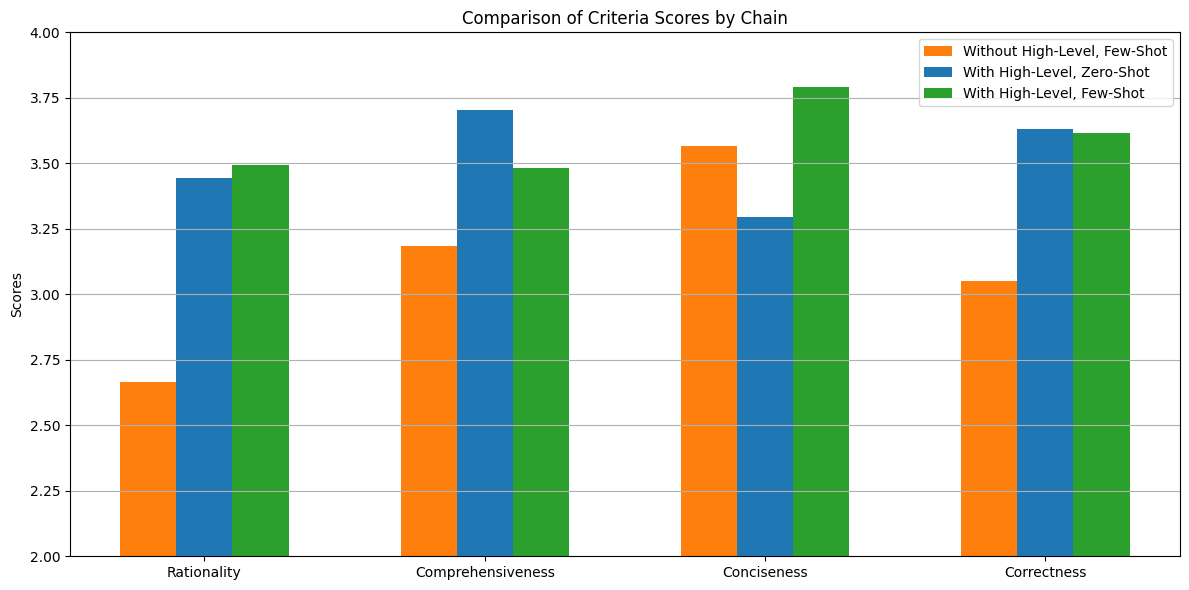

In [33]:
def plot_summary(summary: dict):
    labels = criteria
    generators = [item["generator_id"] for item in summary]
    scores = [[item[criterion] for criterion in criteria] for item in summary if item["generator_id"] in generators]

    x = np.arange(len(labels))
    width = 0.2
    group_width = len(generators) * width

    _, ax = plt.subplots(figsize=(12, 6))
    for i, (generator, score) in enumerate(zip(generators, scores)):
        ax.bar(
            x - group_width / 2 + i * width + width / 2,
            score,
            width,
            label=chain_names[generator],
            color=chain_colors[generator]
        )

    ax.set_title('Comparison of Criteria Scores by Chain')
    ax.grid(axis='y')
    ax.set_xticks(x)
    ax.set_xticklabels([label.replace("_score", "").capitalize() for label in labels], rotation=0, ha='center')
    ax.legend()
    ax.set_ylabel('Scores')
    ax.set_ylim(2, 4)

    plt.tight_layout()
    plt.show()

full_cleaning_summary = next(
    summary["summary"] for summary in summaries if summary["summary_name"] == FULL_CLEANING_SUMMARY_NAME
)

plot_summary(full_cleaning_summary)


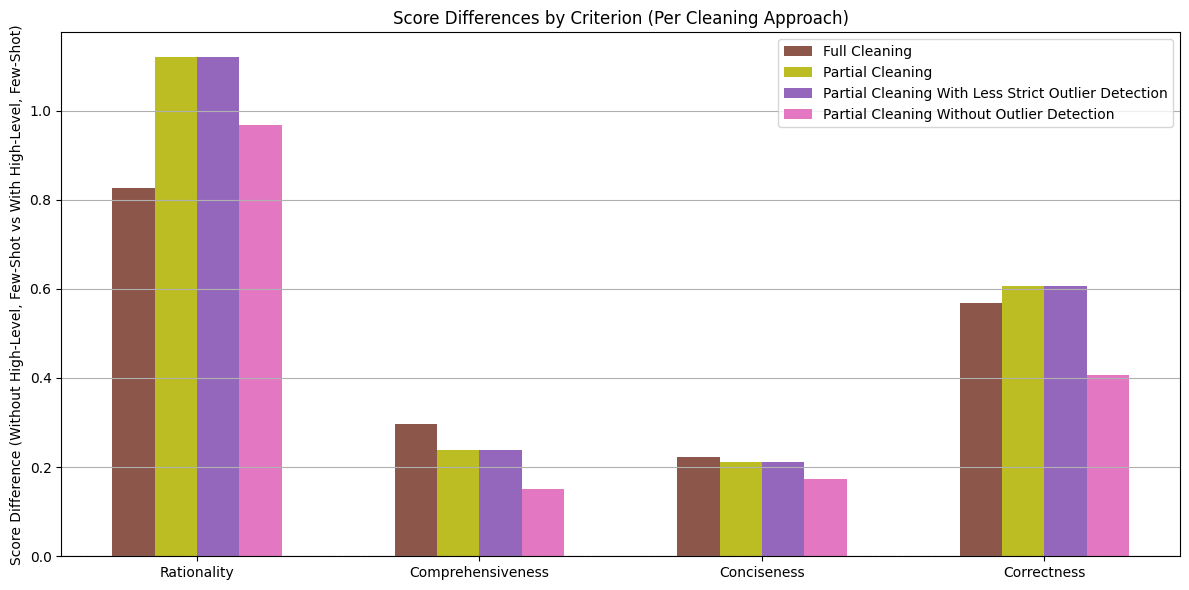

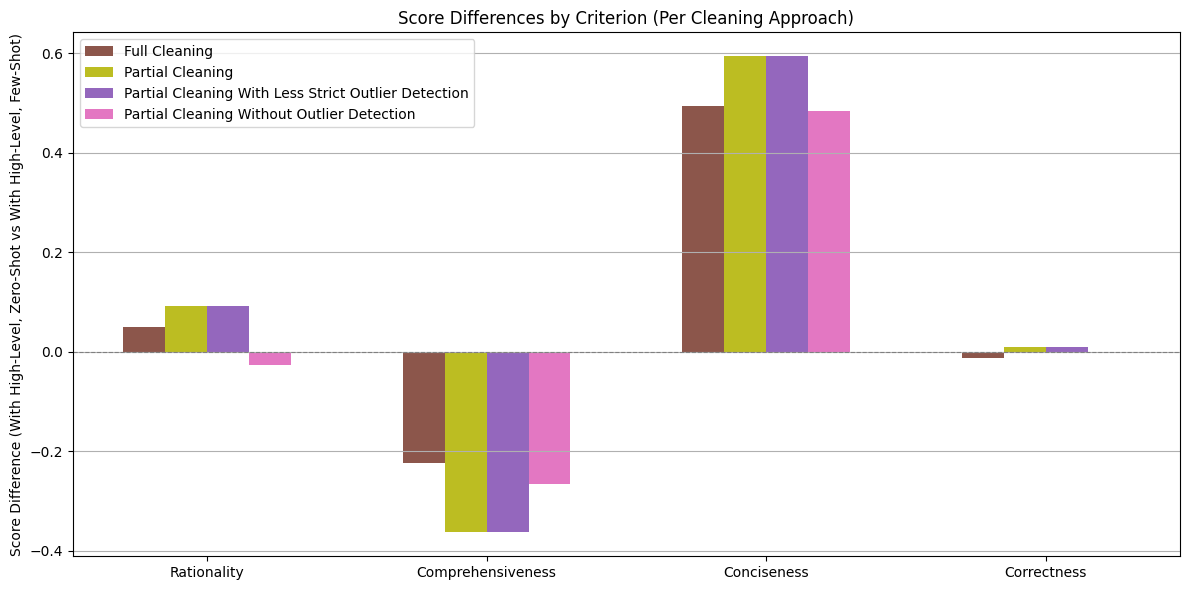

In [34]:
def plot_differences_per_summary(base_generator_id: str, target_generator_id: str): 
    diffs = []

    for summary in summaries:
        summary_name = summary["summary_name"]
        data = summary["summary"]
        a_scores = next(item for item in data if item["generator_id"] == target_generator_id)
        b_scores = next(item for item in data if item["generator_id"] == base_generator_id)
        diff = [a_scores[c] - b_scores[c] for c in criteria]
        diffs.append(diff)

    x = np.arange(len(criteria))
    width = 0.15

    _, ax = plt.subplots(figsize=(12, 6))

    for i, (summary_name, diff) in enumerate(zip(summary_names, diffs)):
        ax.bar(x + i * width, diff, width, label=summary_name, color=summary_name_colors[summary_name])

    ax.axhline(0, color='gray', linewidth=0.8, linestyle='--')
    ax.set_xticks(x + width * (len(summary_names) - 1) / 2)
    ax.set_xticklabels([c.replace("_score", "").capitalize() for c in criteria])

    ax.set_ylabel(f"Score Difference ({chain_names[base_generator_id]} vs {chain_names[target_generator_id]})")
    ax.set_title("Score Differences by Criterion (Per Cleaning Approach)")

    ax.legend()
    ax.grid(axis='y')

    plt.tight_layout()
    plt.show()

plot_differences_per_summary(
    LOW_LEVEL_FEW_SHOT_GENERATOR_NAME,
    HIGH_LEVEL_FEW_SHOT_GENERATOR_NAME
)

plot_differences_per_summary(
    HIGH_LEVEL_ZERO_SHOT_GENERATOR_NAME,
    HIGH_LEVEL_FEW_SHOT_GENERATOR_NAME
)


Cleaning scores based on rules...
Total cleaned individual responses: 159
Percentage of cleaned individual responses: 57.19%
Total remaining individual responses: 119
Cleaning completed.


Cleaning outliers...
Total cleaned individual responses: 38
Percentage of cleaned individual responses: 31.93%
Total remaining individual responses: 81
Outliers cleaned.



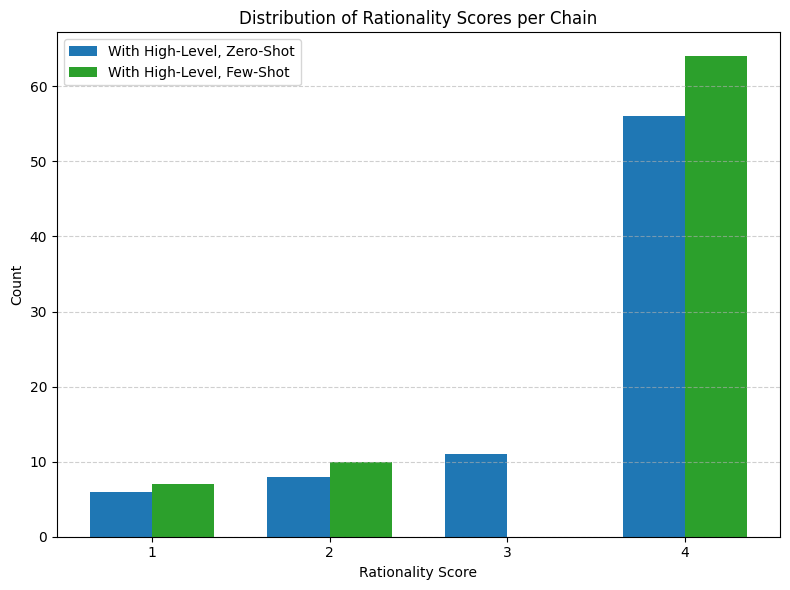

In [35]:
default_summary_task_model = SUMMARY_TASK_MODELS[0]

cleaned_test_case_scores = test_case_scores

for cleaner in default_summary_task_model.cleaners:
    cleaned_test_case_scores = cleaner.clean(cleaned_test_case_scores, default_summary_task_model.partial_cleaning)

def plot_rationality_score_distribution(
    test_case_scores: list[TestCaseScore],
    generator_ids: tuple[str, str]
) -> None:
    if len(generator_ids) != 2:
        raise ValueError("Exactly two generator IDs must be supplied.")


    counts: dict[str, dict[int]] = {
        gid: {1: 0, 2: 0, 3: 0, 4: 0} for gid in generator_ids
    }

    for test_case_score in test_case_scores:
        for generator_score in test_case_score.scores:
            generator_id = generator_score.generator_id
            if generator_id in generator_ids:
                for commit_score in generator_score.scores:
                    score = commit_score.rationality_score
                    if score in (1, 2, 3, 4):
                        counts[generator_id][score] += 1

    x = np.arange(4)
    width = 0.35

    _, ax = plt.subplots(figsize=(8, 6))

    for i, generator_id in enumerate(generator_ids):
        heights = [counts[generator_id][s] for s in (1, 2, 3, 4)]
        label = chain_names.get(generator_id, generator_id) 
        ax.bar(
            x + i * width,
            heights,
            width,
            label=label,
            color=chain_colors.get(generator_id, None),
        )


    ax.set_xlabel("Rationality Score")
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(["1", "2", "3", "4"])

    ax.set_ylabel("Count")

    ax.set_title("Distribution of Rationality Scores per Chain")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

plot_rationality_score_distribution(
    cleaned_test_case_scores,
    (
        HIGH_LEVEL_ZERO_SHOT_GENERATOR_NAME,
        HIGH_LEVEL_FEW_SHOT_GENERATOR_NAME,
    ),
)

# Jira Ticket Distribution

In [36]:
context_folder = CONTEXT_DATA_PATH
separator = END_DOCUMENT_SPLIT_SEPARATOR

def collect_issue_types(context_folder):
    issue_types = []

    for txt_file in Path(context_folder).rglob("*.txt"):
        with open(txt_file, "r", encoding="utf-8") as file:
            content = file.read()
            documents = content.split(separator)
            for doc in documents:
                match = re.search(r"Issue Type:\s*(.+)", doc)
                if match:
                    issue_type = match.group(1).strip()
                    issue_types.append(issue_type)

    return issue_types

def calculate_issue_type_percentages(issue_types):
    total = len(issue_types)
    counter = Counter(issue_types)
    percentages = {issue_type: (count / total) * 100 for issue_type, count in counter.items()}
    return percentages

issue_types = collect_issue_types(context_folder)
percentages = calculate_issue_type_percentages(issue_types)

for issue_type, pct in sorted(percentages.items(), key=lambda x: -x[1]):
    print(f"{issue_type}: {pct:.2f}%")


Bug: 64.06%
New Feature: 17.19%
Improvement: 12.50%
Sub-task: 4.69%
Task: 1.56%
